In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers, optimizers, metrics

2022-02-15 12:48:15.154354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-15 12:48:15.154434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
train_ds, = tfds.load(
    'ag_news_subset',
    split=['train[:50%]'],
    as_supervised=True)

itr = iter(train_ds)
next(itr)

2022-02-15 12:48:25.877272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-15 12:48:25.877360: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-15 12:48:25.877426: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-19319V3): /proc/driver/nvidia/version does not exist
2022-02-15 12:48:25.880684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<tf.Tensor: shape=(), dtype=string, numpy=b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>)

In [ ]:
VOCAB_SIZE = 5000
SEQ_LEN = 64
NUM_CLASSES = 4
LEARNING_RATE = .001

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LEN)
encoder.adapt(train_ds.map(lambda text, label: text))

def encode_fn(text, label):
    return (encoder(text), label)

In [ ]:
def create_model():
    text = tf.keras.Input(shape=(SEQ_LEN), dtype=tf.float32)
    embedding = layers.Embedding(len(encoder.get_vocabulary()), 64)(text)
    
    self_attention = layers.Attention()([embedding, embedding])
    flattened = layers.Flatten()(self_attention)
    output = layers.Dense(4, activation='softmax')(flattened)
    
    model = tf.keras.Model(inputs=[text], outputs=[output])
    
    adam = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = 'sparse_categorical_crossentropy'
    metrics = 'accuracy'
    
    model.compile(optimizer=adam, loss=loss, metrics=metrics)
    return model

model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 64, 64)       320000      ['input_6[0][0]']                
                                                                                                  
 attention_1 (Attention)        (None, 64, 64)       0           ['embedding_5[0][0]',            
                                                                  'embedding_5[0][0]']            
                                                                                                  
 flatten_1 (Flatten)            (None, 4096)         0           ['attention_1[0][0]']      

In [ ]:
model.fit(train_ds.batch(256).map(encode_fn), epochs=5)

Epoch 1/5
235/235 [==============================] - 12s 46ms/step - loss: 0.6550 - accuracy: 0.7823
Epoch 2/5
235/235 [==============================] - 11s 47ms/step - loss: 0.3117 - accuracy: 0.8975
Epoch 3/5
235/235 [==============================] - 11s 49ms/step - loss: 0.2700 - accuracy: 0.9090
Epoch 4/5
235/235 [==============================] - 11s 48ms/step - loss: 0.2478 - accuracy: 0.9151
Epoch 5/5
235/235 [==============================] - 11s 46ms/step - loss: 0.2333 - accuracy: 0.9196


In [ ]:
def decode(items, vocab):
    text_items = []
    for item in items:
#         text_item = [(index, token.numpy(), vocab[token]) for index, token in enumerate(item)]
        text_item = [vocab[token] for token in item]
        
        text_items.append(text_item)
    
    return text_items

def get_attention_scores(text):
    # Extract embedding and attention layers from the model
    embedding_layer, attention_layer = model.layers[1], model.layers[2]
    encoding = encoder([text])
    embedding = embedding_layer(encoding)
    
    # We use the same embedding to perform self-attention
    _, scores = attention_layer([embedding, embedding], return_attention_scores=True)
    
    return encoding, scores

text = "Rupert Murdoch #39;s News Corporation today took steps to head off a potential takeover by rival mogul John Malone with a  quot;poison pill quot; plan to dilute the shareholdings of would-be predators."
encoding, scores = get_attention_scores(text)
text_tokens = decode(encoding, encoder.get_vocabulary())
print('Text tokens: ', text_tokens)
print('Tokens: ', encoding)
print('Self-Attention scores: ', scores)

Text tokens:  [['rupert', 'murdoch', '39s', 'news', 'corporation', 'today', 'took', 'steps', 'to', 'head', 'off', 'a', 'potential', 'takeover', 'by', 'rival', '[UNK]', 'john', '[UNK]', 'with', 'a', '[UNK]', '[UNK]', 'quot', 'plan', 'to', '[UNK]', 'the', '[UNK]', 'of', '[UNK]', '[UNK]', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]
Tokens:  tf.Tensor(
[[3626 3688   11  129 1404   80  309 2393    4  303  106    3 1069  694
    18  409    1  218    1   12    3    1    1   83  248    4    1    2
     1    5    1    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 64), dtype=int64)
Self-Attention scores:  tf.Tensor(
[[[0.02609748 0.02851956 0.0181938  ... 0.01508285 0.01508285 0.01508285]
  [0.0276615  0.04025185 0.01893727 ... 0.01453829 0.01453829 0.01453829]
  [0.01833969 0.0196

In [ ]:
scores[0, 4]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0.01683364, 0.02314224, 0.01643265, 0.01896303, 0.0370173 ,
       0.01553664, 0.01117901, 0.01904086, 0.01551224, 0.01027294,
       0.01754347, 0.01482745, 0.01072181, 0.02153939, 0.01743654,
       0.01658158, 0.01486312, 0.01386998, 0.01486312, 0.01363553,
       0.01482745, 0.01486312, 0.01486312, 0.01445088, 0.01655908,
       0.01551224, 0.01486312, 0.01399966, 0.01486312, 0.0166438 ,
       0.01486312, 0.01486312, 0.01496924, 0.01496924, 0.01496924,
       0.01496924, 0.01496924, 0.01496924, 0.01496924, 0.01496924,
       0.01496924, 0.01496924, 0.01496924, 0.01496924, 0.01496924,
       0.01496924, 0.01496924, 0.01496924, 0.01496924, 0.01496924,
       0.01496924, 0.01496924, 0.01496924, 0.01496924, 0.01496924,
       0.01496924, 0.01496924, 0.01496924, 0.01496924, 0.01496924,
       0.01496924, 0.01496924, 0.01496924, 0.01496924], dtype=float32)>

In [ ]:
def create_rnn_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(SEQ_LEN), dtype=tf.float32),
        layers.Embedding(len(encoder.get_vocabulary()), 62),
        layers.RNN(layers.GRUCell(SEQ_LEN)),
        layers.Dense(4, activation='softmax')
    ])
    
    adam = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = 'sparse_categorical_crossentropy'
    metrics = 'accuracy'
    
    model.compile(optimizer=adam, loss=loss, metrics=metrics)
    return model

rnn_model = create_rnn_model()
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 64, 62)            310000    
                                                                 
 rnn_5 (RNN)                 (None, 64)                24576     
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 334,836
Trainable params: 334,836
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_model.fit(train_ds.batch(256).map(encode_fn), epochs=5)

Epoch 1/5
235/235 [==============================] - 31s 124ms/step - loss: 1.3863 - accuracy: 0.2525
Epoch 2/5
235/235 [==============================] - 29s 123ms/step - loss: 1.3329 - accuracy: 0.3023
Epoch 3/5
235/235 [==============================] - 28s 117ms/step - loss: 0.8278 - accuracy: 0.5762
Epoch 4/5
235/235 [==============================] - 29s 124ms/step - loss: 0.4669 - accuracy: 0.8379
Epoch 5/5
235/235 [==============================] - 30s 126ms/step - loss: 0.3242 - accuracy: 0.8948


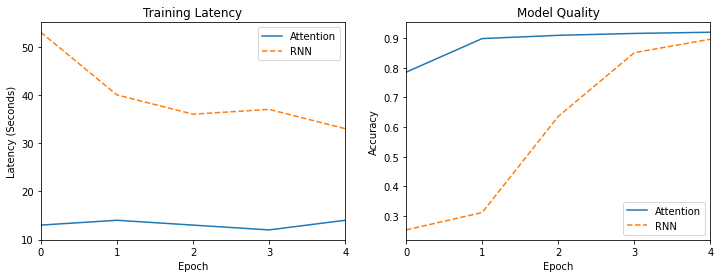

In [ ]:
# !pip install matplotlib

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

runtimes = {
    'attention': [13, 14, 13, 12, 14],
    'rnn': [53, 40, 36, 37, 33]
}

accuracies = {
    'attention': [0.7851, 0.8984, 0.9094, 0.9158, 0.9198],
    'rnn': [0.2532, 0.3118, 0.6359, 0.8510, 0.8963]
}

epochs = range(5)

fig, plts = plt.subplots(1, 2, figsize=(12, 4))
ttplt = plts[0]
accplt = plts[1]
# figs[0

ttplt.plot(runtimes['attention'], label='Attention')
ttplt.plot(runtimes['rnn'], label='RNN', ls='--')

ttplt.xaxis.set_major_locator(MaxNLocator(integer=True))
ttplt.axes.set_xlim([0, 4])
ttplt.set_xlabel('Epoch')
ttplt.set_ylabel('Latency (Seconds)')
ttplt.set_title('Training Latency')
ttplt.legend()

accplt.plot(accuracies['attention'], label='Attention')
accplt.plot(accuracies['rnn'], label='RNN', ls='--')

accplt.xaxis.set_major_locator(MaxNLocator(integer=True))
accplt.axes.set_xlim([0, 4])
accplt.set_xlabel('Epoch')
accplt.set_ylabel('Accuracy')
accplt.set_title('Model Quality')
accplt.legend()

fig.show()

# figs, axes
# plt.plot(runtimes['attention'], label='Attention')
# plt.plot(runtimes['rnn'], label='RNN')

# plt.xlabel('Epoch')
# plt.ylabel('Training Time (Seconds)')
# plt.title('Model Training Times')
# plt.legend()
# plt.show()

### Benchmark

In [ ]:
def convert_to_tflite(model, output_file=None):
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    
    tflite_model = converter.convert()
    open(output_file, "wb").write(tflite_model) if output_file else None
    
    return tflite_model

rnn_tflite = convert_to_tflite(rnn_model, 'rnn_model.tflite')
# attention_tflite = convert_to_tflite(model, 'attention_model.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp9zpk3qmd/assets


INFO:tensorflow:Assets written to: /tmp/tmp9zpk3qmd/assets
2022-02-15 16:36:59.432793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-02-15 16:36:59.432908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-02-15 16:36:59.433581: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp9zpk3qmd
2022-02-15 16:36:59.443814: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-02-15 16:36:59.443858: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmp9zpk3qmd
2022-02-15 16:36:59.481861: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-02-15 16:36:59.636664: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmp9zpk3qmd
2022-02-15 16:36:59.711490: I tensorflow/cc/saved_model/loader.cc:283] SavedMode

In [ ]:
# keras_model = build_keras_lstm(rnn_model)
# lstm_tflite = convert_to_tflite(lstm_model, 'lstm_model.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp3zkyswbj/assets


INFO:tensorflow:Assets written to: /tmp/tmp3zkyswbj/assets
2022-02-15 13:04:41.145641: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-02-15 13:04:41.145694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-02-15 13:04:41.146000: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp3zkyswbj
2022-02-15 13:04:41.150344: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-02-15 13:04:41.150366: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmp3zkyswbj
2022-02-15 13:04:41.170341: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-02-15 13:04:41.231018: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmp3zkyswbj
2022-02-15 13:04:41.288585: I tensorflow/cc/saved_model/loader.cc:283] SavedMode